# DAT200 CA4 2023
#### Karin Mollatt
Kaggle username: karinmollatt

---

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline      import make_pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

### Reading data

In [2]:
# loading data
train_df =  pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

### Data exploration and visualisation
I visualize the raw data with barplots, violin- and scatterplots to inspect for possible outliers or inconsistencies, and to observe if this can have an impact on the model afterwards. Boxplots are also used to visually identify outliers.

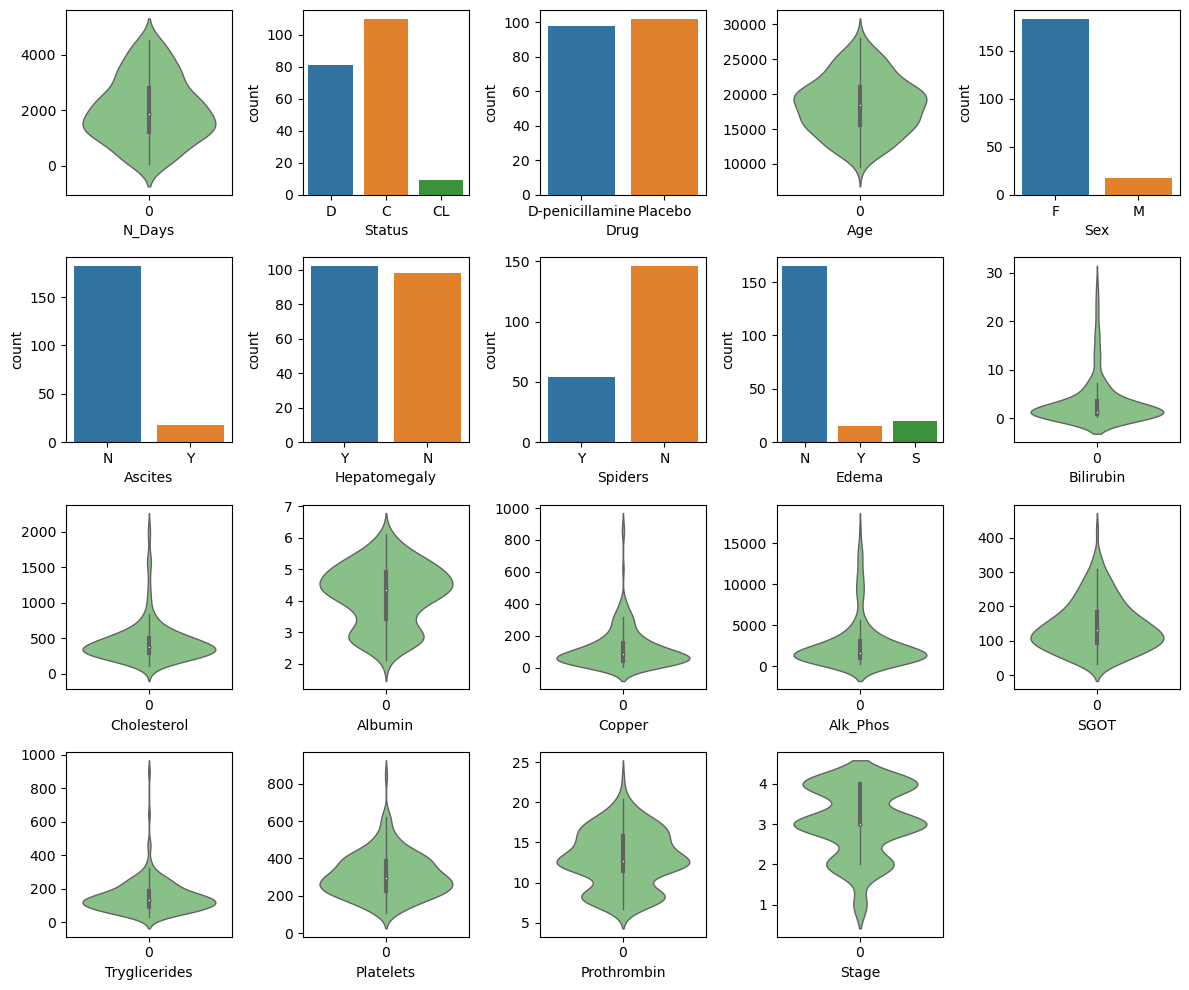

In [3]:
# violinplot for continous features, and barplots for categorical features 
row_no = 4
col_no = 5
subplot_no = 1

plt.figure(figsize=(12,10))

for col in train_df.columns:
    
    # if categorical (dtype is object), then barplot
    if train_df[col].dtype == "object":
        plt.subplot(row_no, col_no, subplot_no)
        plt.xlabel(col)
        sns.countplot(x=col, data=train_df)
    # if categorical (dtype is int64 or float64), then violinplot
    else:
        plt.subplot(row_no, col_no, subplot_no)
        plt.xlabel(col)
        sns.violinplot(data=train_df[col], scale='count', linewidth=1, palette='Accent')
    
    subplot_no = subplot_no + 1

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

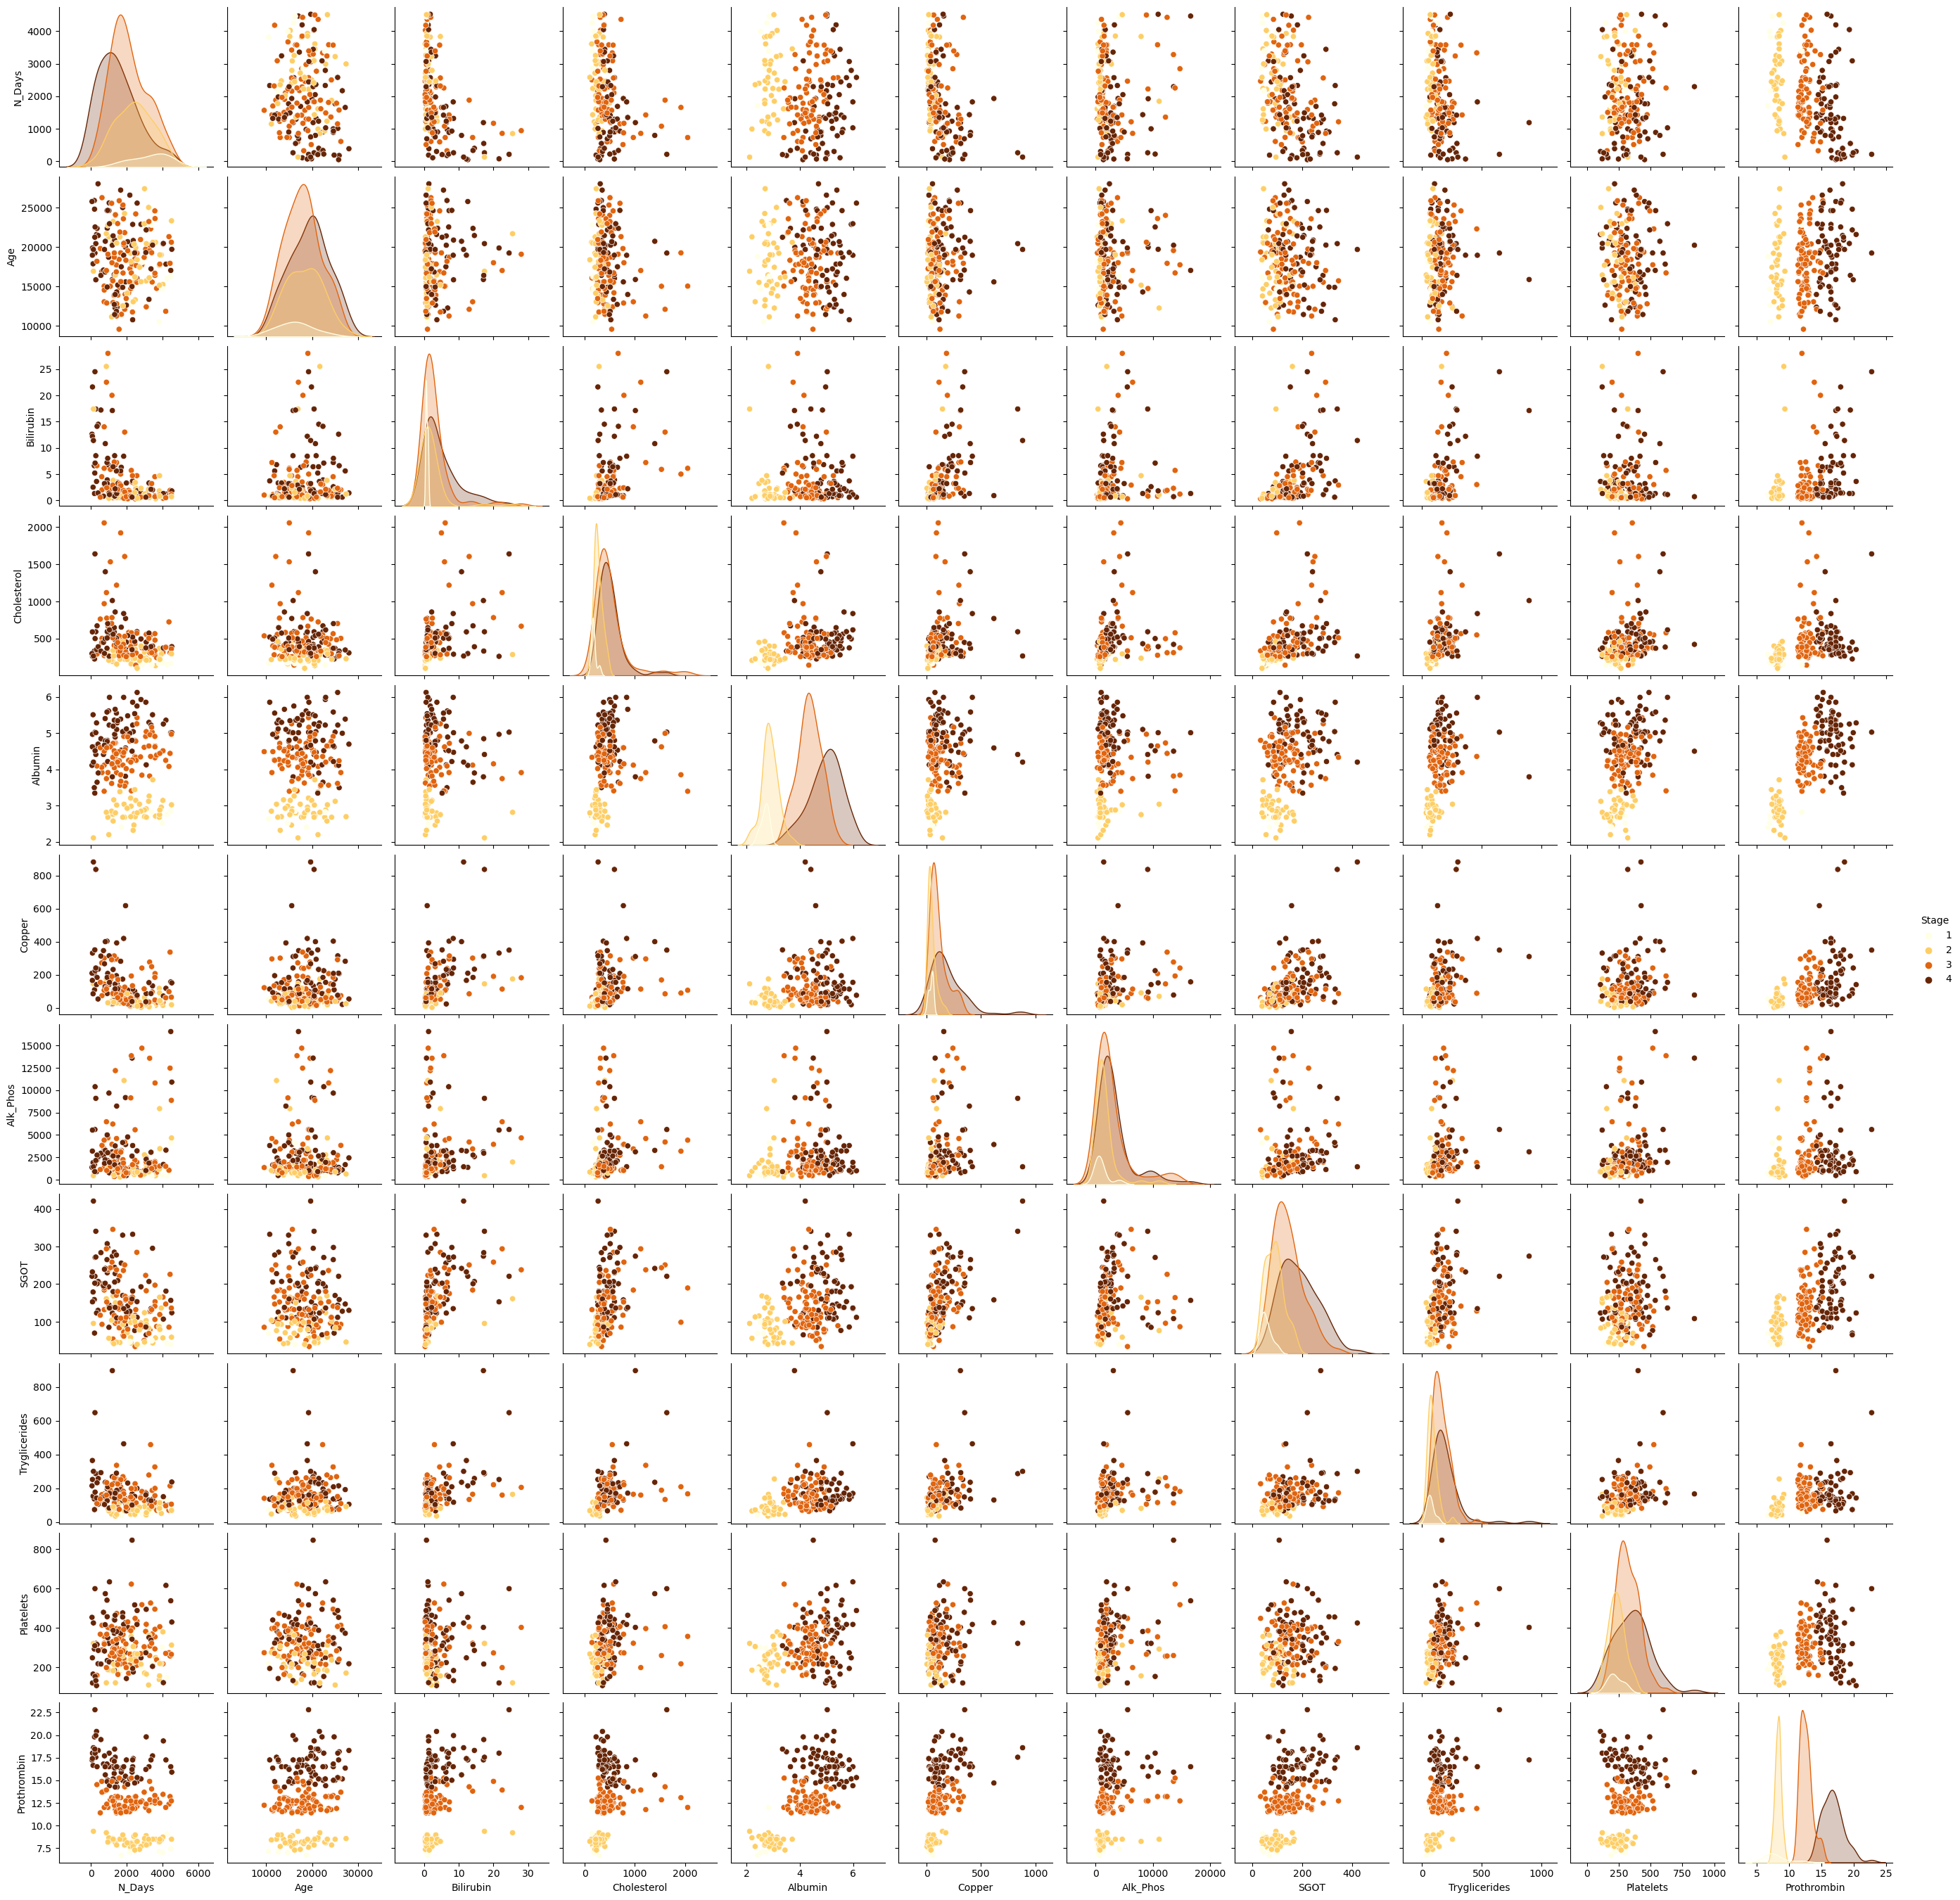

In [4]:
# pairplot
plt.figure()
sns.pairplot(train_df, hue='Stage', palette='YlOrBr')
plt.show()

<Figure size 640x480 with 0 Axes>

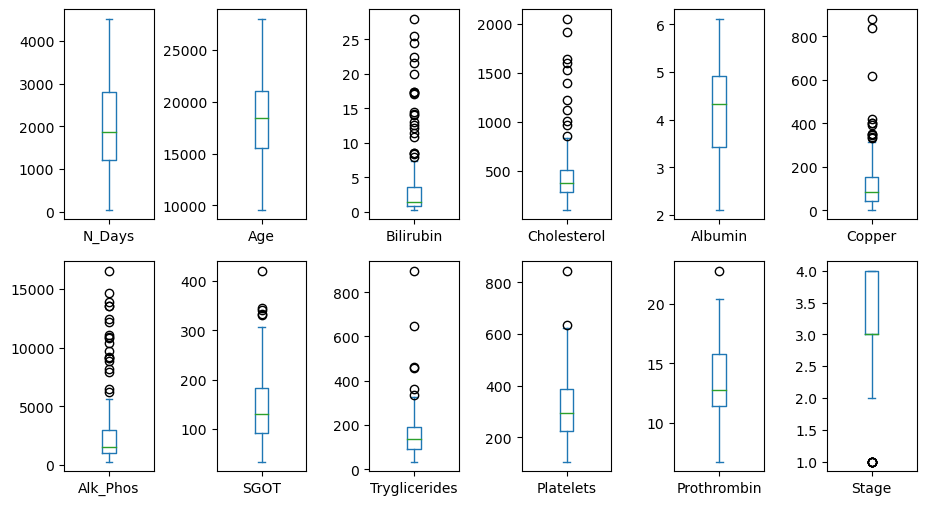

In [5]:
# box plot
plt.figure()
train_df.plot(kind='box', 
              subplots=True, 
              layout=(2, 6),
              figsize=(11,6),
              sharex=False, 
              sharey=False)
plt.subplots_adjust(wspace=0.7) 
plt.show()

From the three visualizations of the raw data, one can observe that some of the continous features have skewed distributions, which is a sign of the data containing outliers. This applies to `Bilirubin`, `Cholesterol`, `Copper`, `Alk_Phos` and `Tryglicerides`.

For the categorical features, one can observe from the barplots that the clear majority of the patients are females. This can be nice to have in mind when reviewing the predictions, because it can have an effect on the result.

### Data cleaning

Since some of the feature data is skewed, one can not use the empirical rule to remove outliers. The Interquartile Range can be used on skewed data, but has a tendency of removing too many rows. Health data is generally hard to collect, so the data sets are often small and one wants to keep as much of the data as possible.

In [6]:
# check of outliers from Interquartile Range
iqr_train_df = train_df.copy()

for col in iqr_train_df:
    
    if train_df[col].dtype == "object":
        continue
    else:
        q75, q25 = np.percentile(iqr_train_df.loc[:,col], [75,25])
        iqr = q75 - q25

        max_val = q75 + (1.5*iqr)
        min_val = q25 - (1.5*iqr)

        iqr_train_df.loc[iqr_train_df[col] < min_val, col] = np.nan
        iqr_train_df.loc[iqr_train_df[col] > max_val, col] = np.nan

sum_iqr_outliers = iqr_train_df.isnull().sum()

print(f'Sum of IQR outliers per feature:\n{sum_iqr_outliers}')
print(f'\nSum of all IQR outliers: {sum(sum_iqr_outliers)}')
print(f'Removing these rows will make up {sum(sum_iqr_outliers)/len(iqr_train_df)*100:.2f}% of the dataset.')

Sum of IQR outliers per feature:
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin        22
Cholesterol      16
Albumin           0
Copper            1
Alk_Phos         20
SGOT              5
Tryglicerides    16
Platelets         4
Prothrombin       1
Stage             8
dtype: int64

Sum of all IQR outliers: 93
Removing these rows will make up 46.50% of the dataset.


As foreseen, the IQR will apply to a large part of the data, and that we want to avoid. Therefore, we proceed with detecting null values instead.

In [7]:
no_null_train = train_df.isnull().sum()
no_null_test = test_df.isnull().sum()

print(f'Number of missing values in training dataset:\n{no_null_train}')
print(f'\nIn total {no_null_train.sum()} missing values, which applies to {no_null_train.sum()/len(train_df)*100:.2f}% of the data.')

print(f'Number of missing values in test dataset:\n{no_null_test}')
print(f'\nIn total {no_null_test.sum()} missing values, which applies to {no_null_test.sum()/len(test_df)*100:.2f}% of the data.')

Number of missing values in training dataset:
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      16
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    16
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In total 37 missing values, which applies to 18.50% of the data.
Number of missing values in test dataset:
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol       9
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    11
Platelets         0
Prothrombin       0
dtype: int64

In total 21 missing values, which applies to 19.27% of the data.


These missing values can be taken care of by perfoming a ***mean imputation***, which replaces the missing values with the mean value of the feature column.

In [8]:
for col in train_df.columns:  
    
    if train_df[col].dtype == "object":
        continue
    else:
        train_df[col].fillna(train_df[col].mean(), inplace=True)

for col in test_df.columns:  
    
    if test_df[col].dtype == "object":
        continue
    else:
        test_df[col].fillna(test_df[col].mean(), inplace=True)

There are now no missing values in our data.

### Data exploration after cleaning

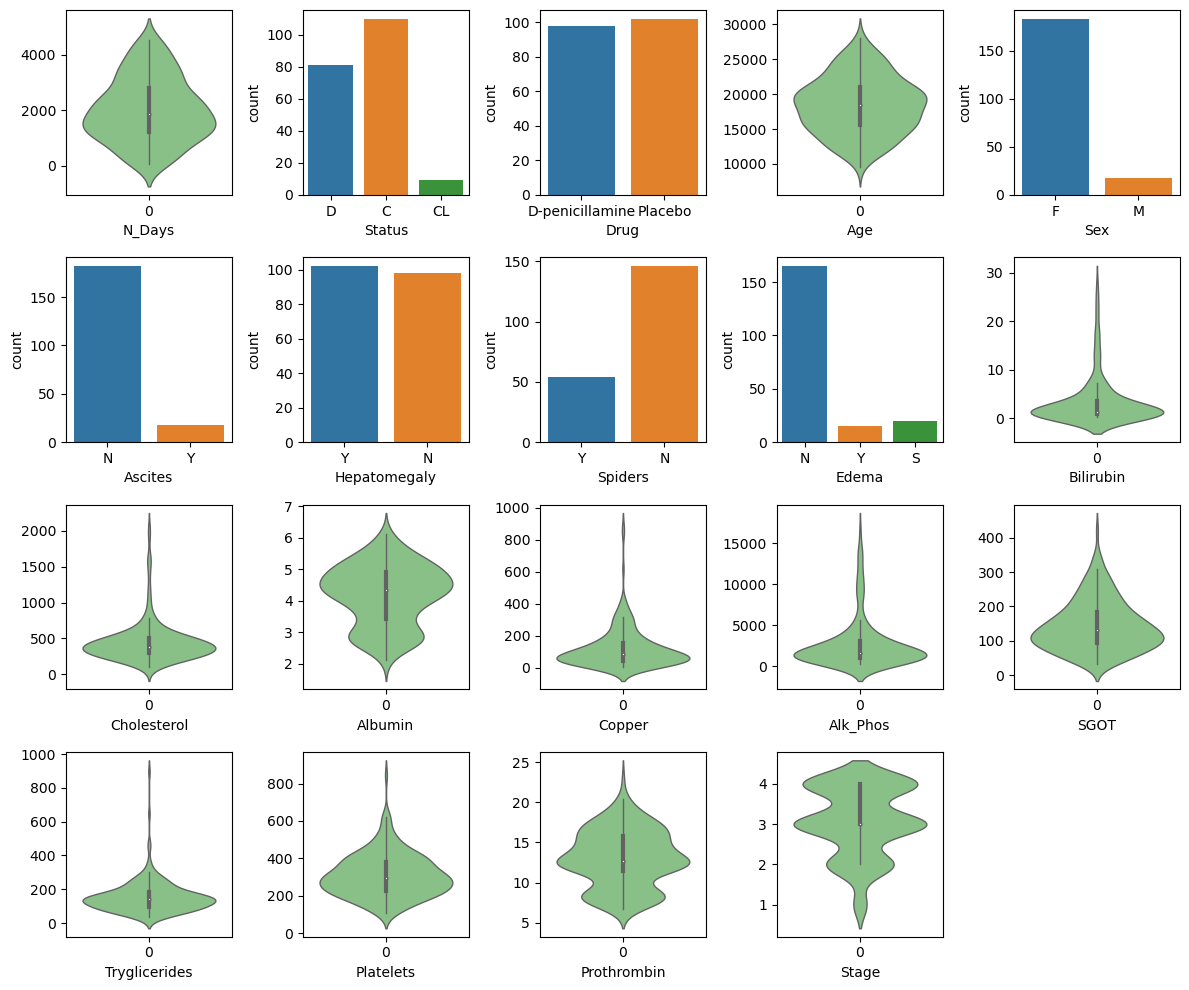

In [9]:
# violinplot for continous features, and barplots for categorical features 
row_no = 4
col_no = 5
subplot_no = 1

plt.figure(figsize=(12,10))

for col in train_df.columns:
    
    # if categorical (dtype is object), then barplot
    if train_df[col].dtype == "object":
        plt.subplot(row_no, col_no, subplot_no)
        plt.xlabel(col)
        sns.countplot(x=col, data=train_df)
    # if categorical (dtype is int64 or float64), then violinplot
    else:
        plt.subplot(row_no, col_no, subplot_no)
        plt.xlabel(col)
        sns.violinplot(data=train_df[col], scale='count', linewidth=1, palette='Accent')
    
    subplot_no = subplot_no + 1

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

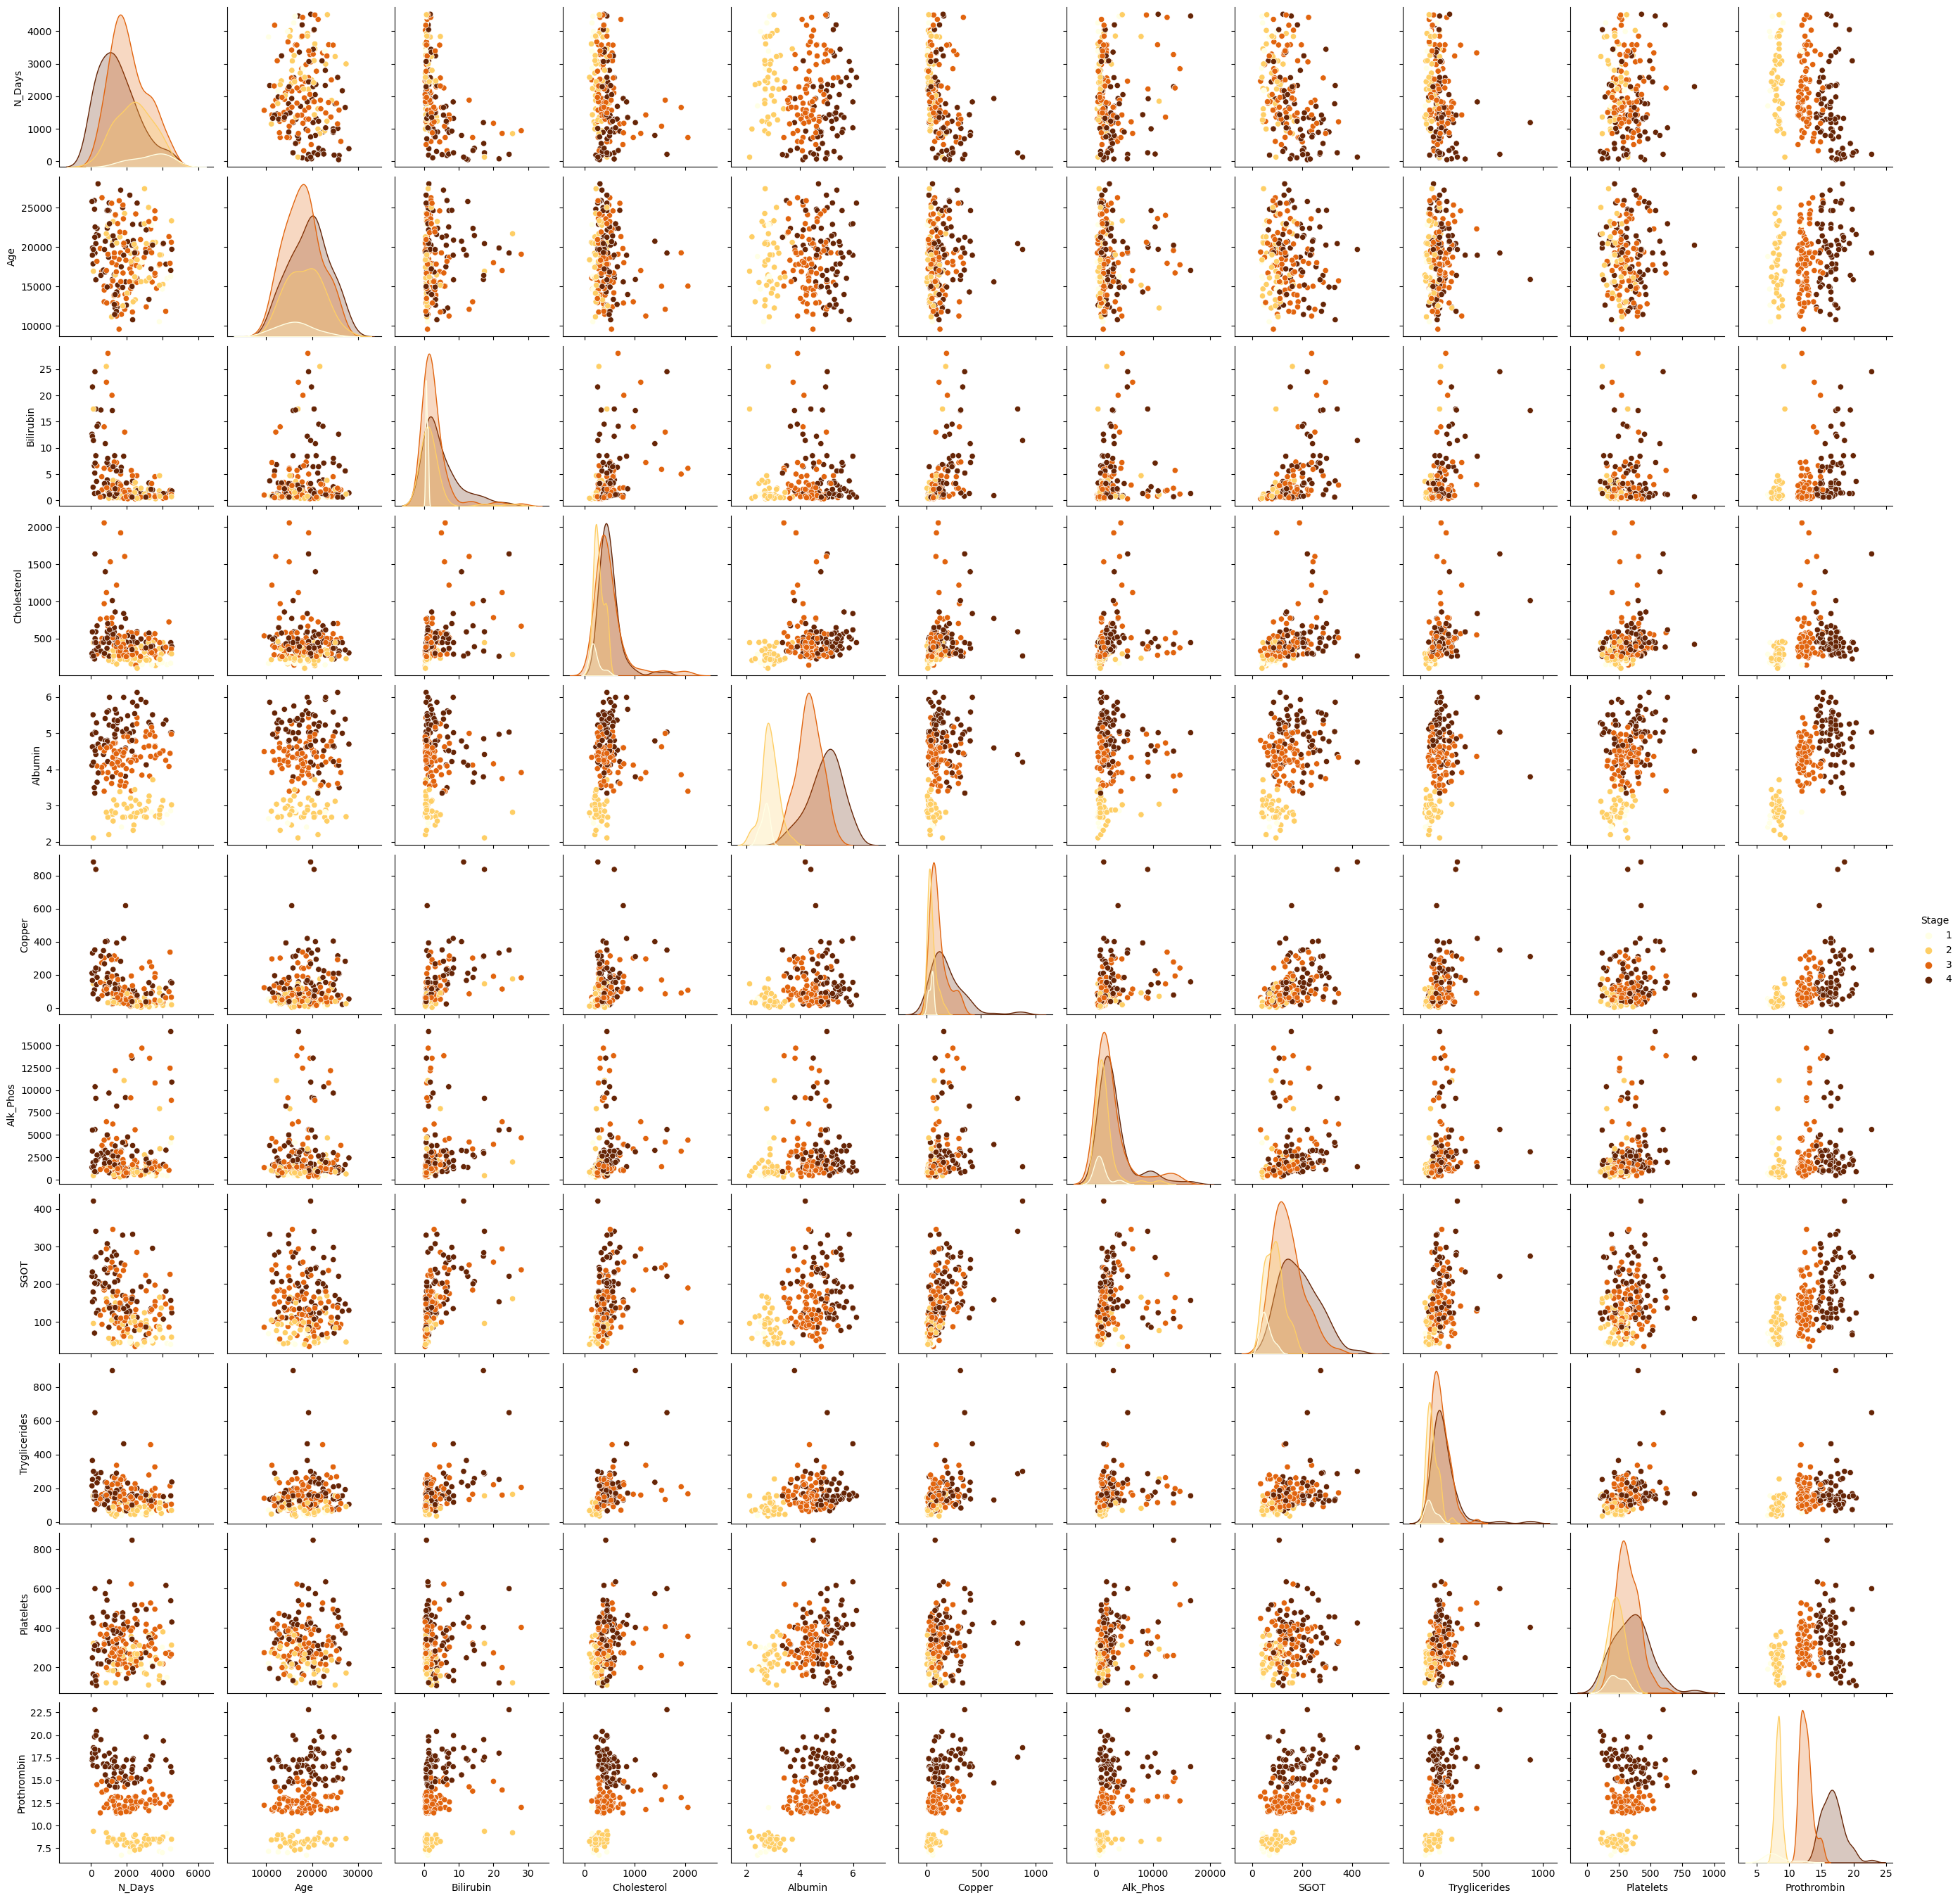

In [10]:
# pairplot
plt.figure()
sns.pairplot(train_df, hue='Stage', palette='YlOrBr')
plt.show()

<Figure size 640x480 with 0 Axes>

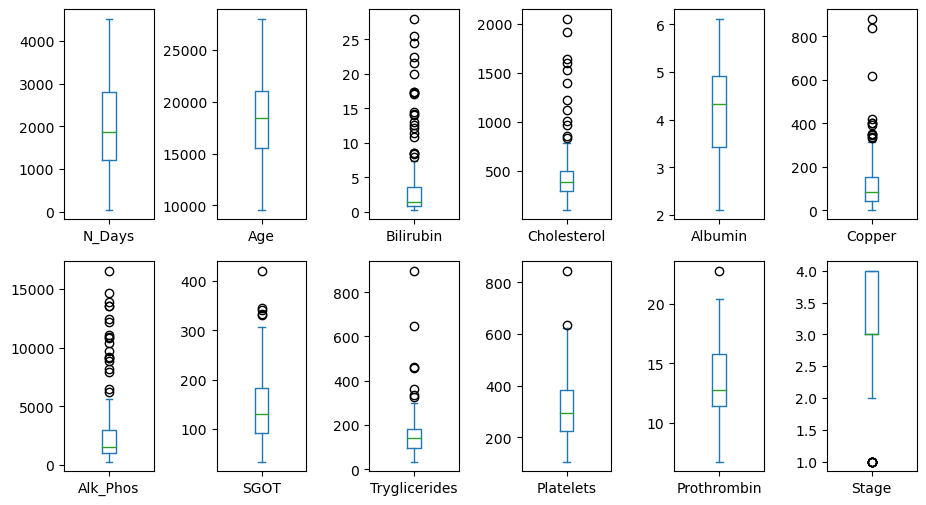

In [11]:
# box plot
plt.figure()
train_df.plot(kind='box', 
              subplots=True, 
              layout=(2, 6),
              figsize=(11,6),
              sharex=False, 
              sharey=False)
plt.subplots_adjust(wspace=0.7) 
plt.show()

As one can observe from the new visualizations, there are approximately no changes. That is because the first plots already ignores the missing values, and since they are replaced with the mean of the feature, it will not have an impact on the plots.

### Data preprocessing

To avoid technical glitches, we provide dummy variables for the categorical features.

In [12]:
# one-hot encoding via pandas
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

#### Train test split

In [13]:
# splitting features and target in two dataframes
features_train_df = train_df.loc[:, train_df.columns != 'Stage']
target_train_df = train_df.loc[:, train_df.columns == 'Stage']

# splitting these dataframes in train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    features_train_df, target_train_df,
    test_size=0.3, random_state=1, stratify=target_train_df)

### Modelling

#### Data pipeline with kernel

In [14]:
# SVM
pipe_svm = make_pipeline(StandardScaler(),    # scaling features
                        PCA(n_components=10),  # dimension reduction with PCA
                        SVC(kernel='rbf', random_state=1)) # Support Vector Classifier

# train every function of pipeline (includes .fit() and .transform())
pipe_svm.fit(X_train, y_train.values.ravel())

# predict class labels from test set
y_pred = pipe_svm.predict(X_test)

print(f'Test Accuracy SVM: {pipe_svm.score(X_test, y_test):.3f}')

# Optimize parameter values via grid search
param_range = [0.0001, 0.001, 0.01, 0.05, 0.5, 0.1, 1.0, 5.0, 10.0, 100.0] # parameter range to iterate over

# hyperparameters to optimize
param_grid_svm = [{'svc__C': param_range,
                   'svc__gamma': param_range,
                   'svc__kernel': ['rbf']}]

# grid search class object
gs_svm = GridSearchCV(estimator=pipe_svm, param_grid=param_grid_svm, 
                      scoring='accuracy', cv=5, refit=True, n_jobs=-1)

# fitting object to data
gs_svm.fit(X_train, y_train.values.ravel())

print(f'Best hyperparameters SVM: {gs_svm.best_params_}')
print(f'Best score SVM: {gs_svm.best_score_:.3f}')


Test Accuracy SVM: 0.817
Best hyperparameters SVM: {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best score SVM: 0.907


#### Data pipeline with regularization

In [15]:
# Logistic Regression
pipe_lr = make_pipeline(StandardScaler(),    # scaling features
                        LDA(n_components=3), # dimension reduction with LDA
                        LogisticRegression(random_state=1, max_iter=1000)) # Logistic Regression

# train every function of pipeline (includes .fit() and .transform())
pipe_lr.fit(X_train, y_train.values.ravel())

# predict class labels from test set
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy LR: {pipe_lr.score(X_test, y_test):.3f}')

# Optimize parameter values via grid search (use param_range defined in previous code chunk)

# hyperparameters to optimize
param_grid_lr = {'logisticregression__C': param_range,
                 'logisticregression__penalty': ['l2']}

# grid search class object
gs_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid_lr, 
                      scoring='accuracy', cv=5, refit=True, n_jobs=-1)

# fitting object to data
gs_lr.fit(X_train, y_train.values.ravel())

print(f'Best hyperparameters LR: {gs_lr.best_params_}')
print(f'Best score LR: {gs_lr.best_score_:.3f}')

Test Accuracy LR: 0.933
Best hyperparameters LR: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}
Best score LR: 0.950


#### Other models used for Kaggle submission

In [16]:
# Random Forest classifier
forest = RandomForestClassifier(random_state=1, n_jobs=-1)

# Optimize parameter values via grid search
n_estimators_range = [i for i in range(100, 1001, 50)] # parameter range to iterate over

# hyperparameters to optimize
param_grid_f = {'n_estimators': n_estimators_range,
              'criterion': ['gini', 'entropy']}

# Define the GridSearchCV object with 5-fold cross-validation
gs_f = GridSearchCV(estimator=forest, param_grid=param_grid_f, 
                      scoring='accuracy', cv=5, refit=True, n_jobs=-1)

# Fit the grid search object to the training data
gs_f.fit(X_train, y_train.values.ravel())

# Print the best hyperparameters and the corresponding score
print('Best parameters Random Forest:', gs_f.best_params_)
print('Best score Random Forest:', gs_f.best_score_)

# predict Random Forest class labels from test set
y_pred_f = gs_f.best_estimator_.predict(test_df)

# converting prediction array to dataframe, and writing to csv-file
final_pred_df_f = pd.DataFrame(y_pred_f, columns=["Stage"]).astype('int')
final_pred_df_f.to_csv('submission_rfc.csv', index=True, index_label="Index", sep=',')

Best parameters Random Forest: {'criterion': 'entropy', 'n_estimators': 800}
Best score Random Forest: 0.9357142857142857


*Performance of Random Forest on Kaggle: 0.91081*

### Final Evaluation

In [17]:
# predict SVM class labels from test set
y_pred_svm = gs_svm.best_estimator_.predict(test_df)

# predict LR class labels from test set
y_pred_lr = gs_lr.best_estimator_.predict(test_df)

*Performance of Support Vector Machine on Kaggle: 0.85108*

*Performance of Logistic Regression on Kaggle: 0.68695*

**Final evaluation:** Support Vector Machine performs acceptable, but a regular Random Forest model performs even better. The Logistic Regression Model does not perform well.

### Kaggle submission

In [18]:
# converting prediction array to dataframe, and writing to csv-file
final_pred_df_svm = pd.DataFrame(y_pred_svm, columns=["Stage"]).astype('int')
final_pred_df_svm.to_csv('submission_svm.csv', index=True, index_label="Index", sep=',')

# converting prediction array to dataframe, and writing to csv-file
final_pred_df_lr = pd.DataFrame(y_pred_lr, columns=["Stage"]).astype('int')
final_pred_df_lr.to_csv('submission_lr.csv', index=True, index_label="Index", sep=',')